# data preproccessing


## import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
pd.set_option('max.rows', None)
pd.set_option('max.columns', None)


from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### configurations
* data_input_path -> string, filepath to data to be read in

* grouping -> boolean, if set to True them many sites are grouped
* reduced_grouping -> boolean, if set to True then less sites grouped, only bedrock sites 'WB' and 'BX are grouped into one class and superficial sites 'SV' and 'SE' are grouped into one class.
* raw -> boolean, if set to True then no grouping done
* drop_semi_bedrock ->  True|False, if set to True then some bedrock sites deemed to be semi-bedrock sites are not used for classification



In [2]:
data_input_path = '../data/raw_data.csv'


grouping = True
reduced_grouping = False
raw = False
drop_semi_bedrock = True

### Import data

In [3]:
my_data = pd.read_csv(data_input_path)

### features

In [4]:
my_data.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232'], dtype=object)

### raw sample names including sample sites and artefacts

In [5]:
my_data['Site'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB',
       'BX', 'PF', 'BM', 'WH', 'SQ', 'BP', 'WN', 'BH', 'PH', 'LB', 'AB',
       'LV', 'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH',
       'PX', 'WF', 'DH', 'NMAG_Gold', 'NMW_Gold', 'NMWGwern', 'UBSS',
       'Cefn', 'Stockley', 'Pucha', 'Woodbury', 'Pimple', 'Wellington',
       'Lyonshall', 'SymondsYatE', 'Madawg', nan], dtype=object)

### define functions for making target classes for classification

In [6]:

def make_classes_grouped(row):
    if row['Geology'] == 'Bedrock':
        if row['Site'] == 'WB' or row['Site'] == 'BX':
            return('WB_BX')
        elif row['Site'] == 'BC' or row['Site'] == 'CS':
            return('BC_CS')
        elif row['Site'] == 'SQ' or row['Site'] == 'BP':
            return('SQ_BP')
        else:
            return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])
        
def make_classes_grouped_reduced(row):
    if row['Geology'] == 'Bedrock':
        if row['Site'] == 'WB' or row['Site'] == 'BX':
            return('WB_BX')
        else:
            return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])

def make_classes_raw(row):
    if row['Geology'] == 'Bedrock':
        return(row['Site'])
    elif row['Geology'] == 'Superficial':
        return(row['Region'])



### targets for classification are made

In [7]:
my_data['class'] = 'init'   

if grouping:
    my_data['class'] = my_data.apply(make_classes_grouped, axis = 1)
elif grouping_reduced:
    my_data['class'] = my_data.apply(make_classes_grouped_reduced, axis = 1)
elif raw:
    my_data['class'] = my_data.apply(make_classes_raw, axis = 1)


In [8]:
if drop_semi_bedrock:
    my_data = my_data[(my_data['class'] != 'BM') & (my_data['class'] != 'BC') & (my_data['class'] != 'BP') ]

### remove '<' signs and commas from feature values

In [9]:
for column_name in my_data.columns.values[9:-1]:
    def fill_less_than(row):
        if 'DL' in  str(row[column_name]):
            return(np.nan)
        if '<' in str(row[column_name]):
            return(float(row[column_name].replace('<', '').replace(',', '')))
        else:
            return(float(row[column_name]))
    my_data[column_name] = my_data.swifter.apply(fill_less_than, axis = 1)

### visualise na values

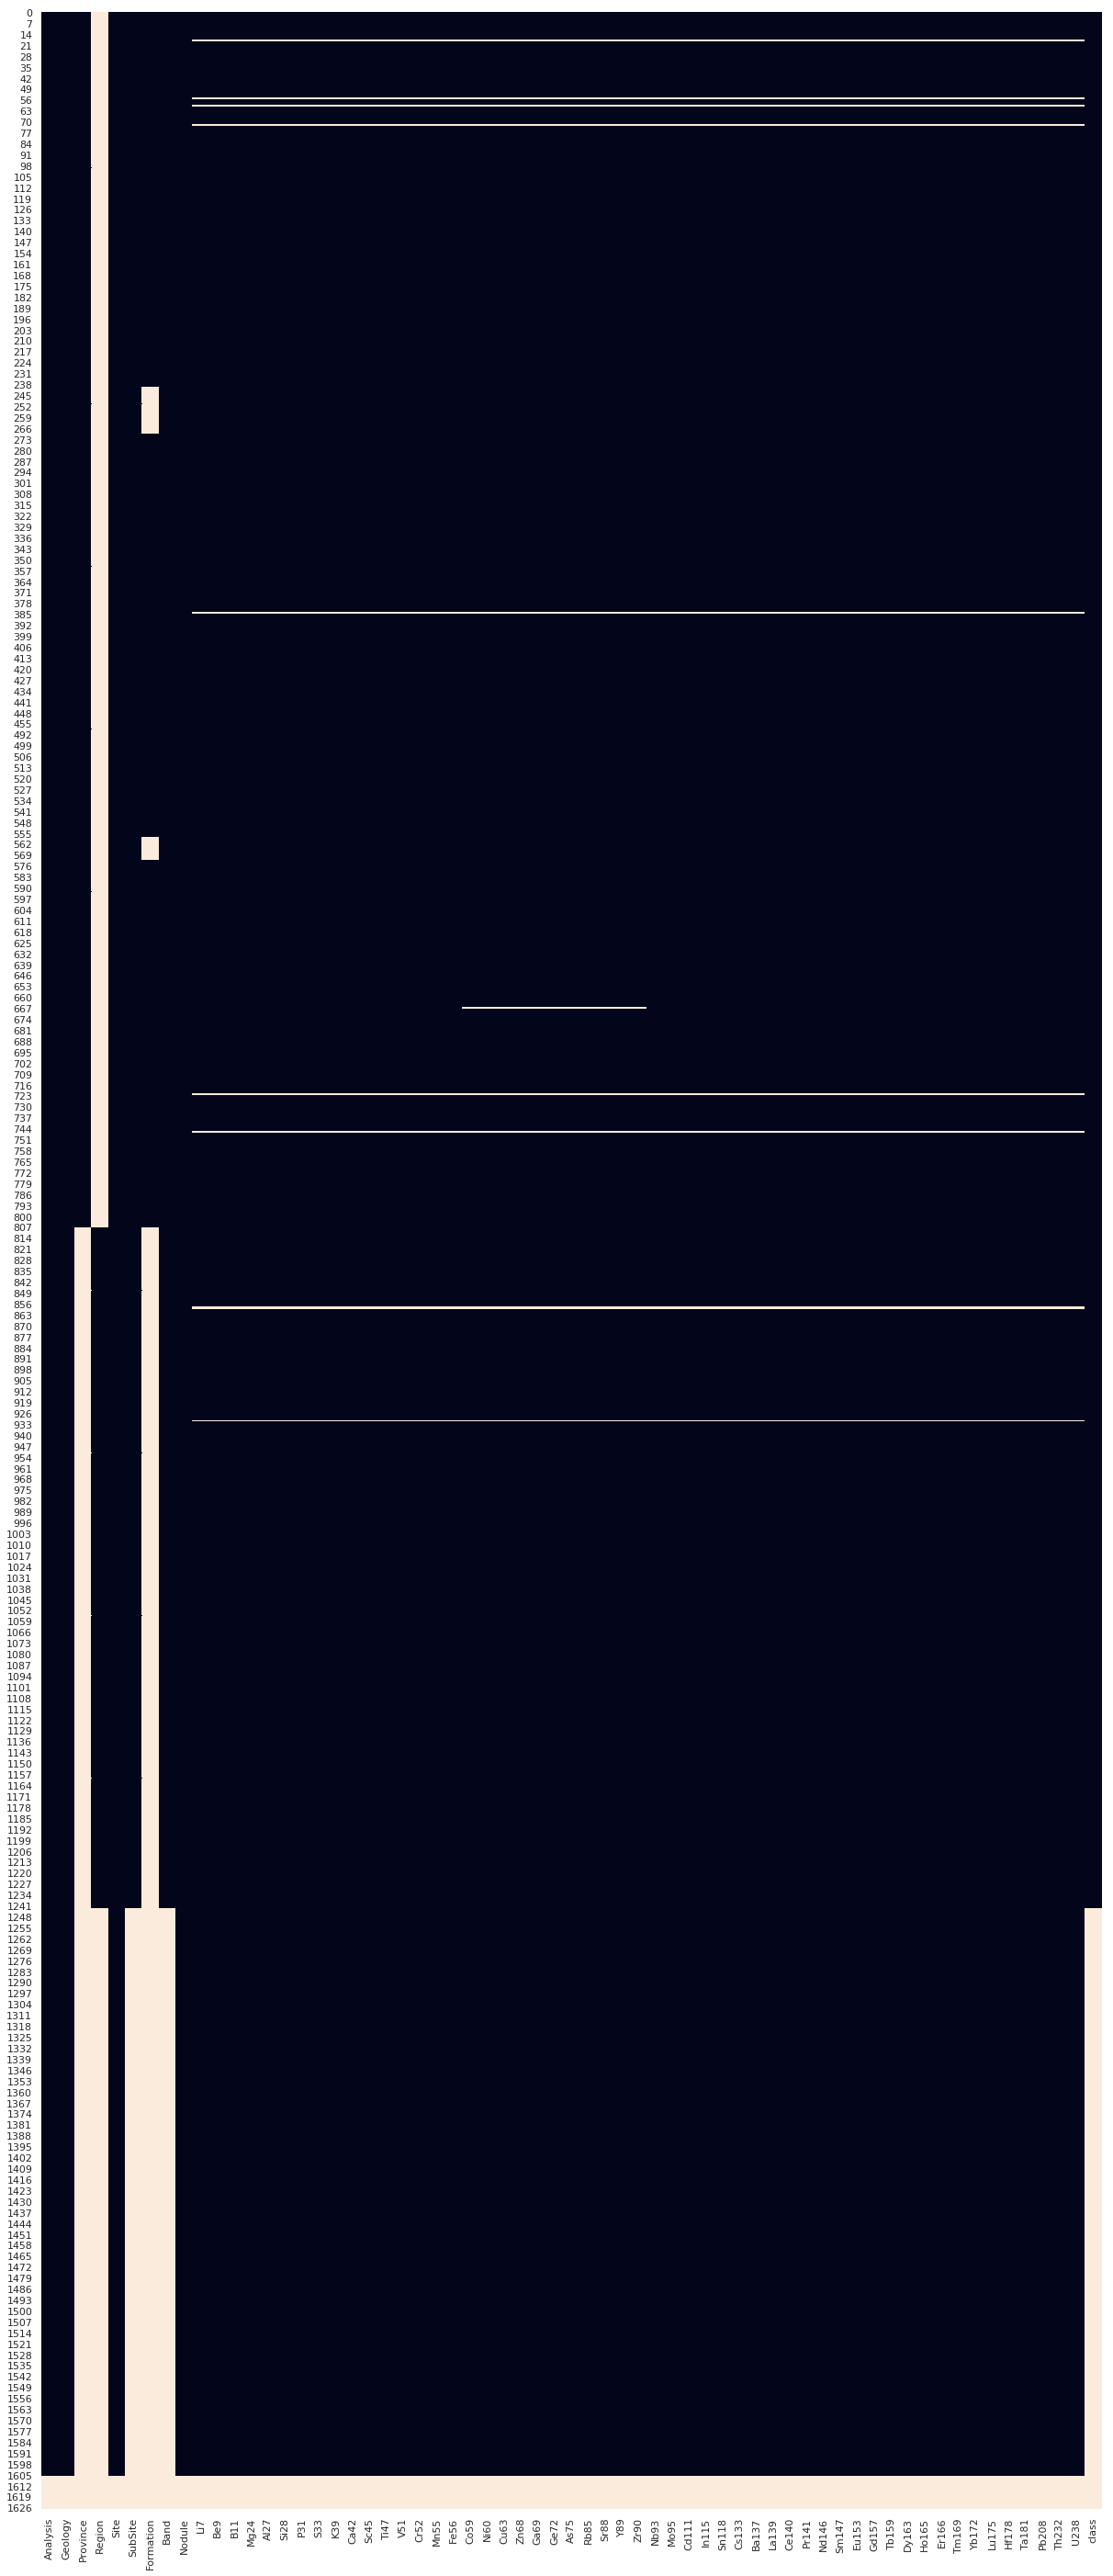

In [10]:
sns.set(rc={'figure.figsize':(20.7,50)})
sns.heatmap(my_data.isna(), cbar=False)

### remove rows where there are all element abundances are na values 

In [11]:
my_data = my_data.dropna(subset=my_data.columns.values[9:-1], how = 'all' , axis = 0)

### Impute na values with feature mean

In [12]:
for column_name in my_data.columns.values[9:-1]:
    my_data[column_name] = my_data[column_name].fillna(my_data[column_name].mean()) 

### Outliers defined as any values that exceed 2 standard deviations from the mean, such values are changed to the mean for that variable

In [13]:
std_dict = {}
mean_dict = {}
median_dict = {}

for col in my_data.columns.values[9:-1]:
    std_dict[col] = my_data[col].std()
    
for col in my_data.columns.values[9:-1]:
    mean_dict[col] = my_data[col].mean()
    
for col in my_data.columns.values[9:-1]:
    median_dict[col] = my_data[col].median()
    

In [14]:
for col_name in my_data.columns.values[9:-1]:
    def impute_outliers(row):
        if np.abs(row[col_name] - mean_dict[col_name]) > 2*(std_dict[col_name]):
            return(mean_dict[col_name])
        else:
            return(row[col_name])
    my_data[col_name]= my_data.swifter.apply(impute_outliers, axis = 1)

### split data into 'train_data' and 'test_data', the former consists of samples from known geological sites and the latter from flint artefacts fow which the original geological source site is unknown and to be predicted.

In [15]:
train_data = my_data[(my_data['Geology']== 'Bedrock') | (my_data['Geology'] == 'Superficial')]
test_data = my_data[my_data['Geology']=='Artefacts']


### label encode the class to be predicted

In [16]:
train_data_formodel = train_data.copy(deep = True)
train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])


### datasets are stored

In [17]:
%store train_data_formodel
%store train_data
%store test_data
%store my_data
%store uniques

Stored 'train_data_formodel' (DataFrame)
Stored 'train_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'my_data' (DataFrame)
Stored 'uniques' (Index)


## data preproccessing for dimensionality reduction and visualisation

### 'training_data' is split into two datasets, one consisting of samples from superficial sites and one containing samples from bedrock sites.

In [18]:
train_data_bedrock = train_data[train_data['Geology'] == 'Bedrock']
train_data_superficial = train_data[train_data['Geology'] == 'Superficial']

### four datasets are created, one containing all train data (bedrock and superficial types), one containing just bedrock types, one containing just superficial types and one containing the artefacts

In [19]:
element_data_train = train_data[train_data.columns.values[9:-1]]
element_data_train_bedrock = train_data_bedrock[train_data.columns.values[9:-1]]
element_data_train_superficial = train_data_superficial[train_data.columns.values[9:-1]]
element_data_test = test_data[test_data.columns.values[9:-1]]

### features are standardised

In [20]:
my_scaler_train = StandardScaler()
my_scaler_train_bedrock = StandardScaler()
my_scaler_train_superficial = StandardScaler()
my_scaler_test = StandardScaler()

In [21]:
element_data_train_scaled = my_scaler_train.fit_transform(element_data_train)
element_data_train_bedrock_scaled = my_scaler_train_bedrock.fit_transform(element_data_train_bedrock)
element_data_train_superficial_scaled = my_scaler_train_superficial.fit_transform(element_data_train_superficial)
element_data_test_scaled = my_scaler_test.fit_transform(element_data_test)

### The four datasets are transformed using Principal component analysis 

In [22]:
my_pca_train = PCA(n_components=element_data_train_scaled.shape[1])
my_pca_train_bedrock = PCA(n_components=element_data_train_bedrock_scaled.shape[1])
my_pca_train_superficial = PCA(n_components=element_data_train_superficial_scaled.shape[1])
my_pca_test = PCA(n_components=element_data_test_scaled.shape[1])

element_data_train_pca = my_pca_train.fit_transform(element_data_train_scaled)
element_data_train_bedrock_pca = my_pca_train_bedrock.fit_transform(element_data_train_bedrock_scaled)
element_data_train_superficial_pca = my_pca_train_superficial.fit_transform(element_data_train_superficial_scaled)
element_data_test_pca = my_pca_test.fit_transform(element_data_test_scaled)

### print details of PCA

In [23]:
print(my_pca_train)

PCA(copy=True, iterated_power='auto', n_components=53, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


### the principal components for the four datasets are put into dataframes

In [24]:
no_PCs = element_data_train_scaled.shape[1]
PC_names = []
for i in range(0, no_PCs):
    number = i + 1
    column_name = 'PC' + str(number)
    PC_names.append(column_name)

In [25]:
PC_df_train = pd.DataFrame(data = element_data_train_pca, columns = PC_names)
PC_df_bedrock_train = pd.DataFrame(data = element_data_train_bedrock_pca, columns = PC_names)
PC_df_superficial_train = pd.DataFrame(data = element_data_train_superficial_pca, columns = PC_names)
PC_df_test = pd.DataFrame(data = element_data_test_pca, columns = PC_names)

### T-Distributed Stochastic Neighbour Embedding is done on the four datasets

In [26]:
my_tsne_train = TSNE(n_components=2, n_iter=750, verbose=3).fit_transform(element_data_train_scaled)
my_tsne_bedrock_train = TSNE(n_components=2, n_iter=750, verbose=3).fit_transform(element_data_train_bedrock_scaled)
my_tsne_superficial_train = TSNE(n_components=2, n_iter=750, verbose=3).fit_transform(element_data_train_superficial_scaled)
my_tsne_test = TSNE(n_components=2, n_iter=750, verbose=3).fit_transform(element_data_test_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1203 samples in 0.004s...
[t-SNE] Computed neighbors for 1203 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1203
[t-SNE] Computed conditional probabilities for sample 1203 / 1203
[t-SNE] Mean sigma: 2.019373
[t-SNE] Computed conditional probabilities in 0.040s
[t-SNE] Iteration 50: error = 72.4487381, gradient norm = 0.1068182 (50 iterations in 3.266s)
[t-SNE] Iteration 100: error = 72.7308350, gradient norm = 0.0992864 (50 iterations in 2.483s)
[t-SNE] Iteration 150: error = 72.6854858, gradient norm = 0.0969545 (50 iterations in 1.655s)
[t-SNE] Iteration 200: error = 73.0849838, gradient norm = 0.0918817 (50 iterations in 1.724s)
[t-SNE] Iteration 250: error = 73.2436142, gradient norm = 0.0965190 (50 iterations in 1.843s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.243614
[t-SNE] Iteration 300: error = 1.4255322, gradient norm = 0.0006456 (50 iterations in 1.786s)

### the t-SNE dimensions for the four datasets are put into dataframes

In [28]:
tsne_df_train = pd.DataFrame(data = my_tsne_train, columns = ['tsne1', 'tsne2', 'tsne3'])
tsne_df_bedrock_train = pd.DataFrame(data = my_tsne_bedrock_train, columns = ['tsne1', 'tsne2', 'tsne3'])
tsne_df_superficial_train = pd.DataFrame(data = my_tsne_superficial_train, columns = ['tsne1', 'tsne2', 'tsne3'])
tsne_df_test = pd.DataFrame(data = my_tsne_test, columns = ['tsne1', 'tsne2', 'tsne3'])

### datasets are stored for the purpose of two-dimensional visualisations

In [29]:
%store PC_df_train
%store my_pca_train

%store PC_df_bedrock_train
%store my_pca_train_bedrock

%store PC_df_superficial_train
%store my_pca_train_superficial

%store PC_df_test
%store my_pca_test

%store tsne_df_train

%store tsne_df_bedrock_train
%store tsne_df_superficial_train


%store tsne_df_test


Stored 'PC_df_train' (DataFrame)
Stored 'my_pca_train' (PCA)
Stored 'PC_df_bedrock_train' (DataFrame)
Stored 'my_pca_train_bedrock' (PCA)
Stored 'PC_df_superficial_train' (DataFrame)
Stored 'my_pca_train_superficial' (PCA)
Stored 'PC_df_test' (DataFrame)
Stored 'my_pca_test' (PCA)
Stored 'tsne_df_train' (DataFrame)
Stored 'tsne_df_bedrock_train' (DataFrame)
Stored 'tsne_df_superficial_train' (DataFrame)
Stored 'tsne_df_test' (DataFrame)
